<a href="https://colab.research.google.com/github/scottthomaswx/WarningPlotter/blob/main/Warning_Plotter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Install Needed Code

In [1]:
# @title
%%capture
!pip install geopandas
!pip install metpy
!pip install requests
!pip install cartopy
!pip install matplotlib
!pip install numpy
import matplotlib.pyplot as plt
import geopandas
from metpy.plots import MapPanel, PanelContainer, PlotGeometry
import requests
import pandas as pd
from metpy.plots import USCOUNTIES
import cartopy.feature as cfeat
import cartopy.crs as ccrs
import matplotlib.patches as mpatches
import numpy as np

#Enter Information To Pull Needed Data

In [5]:
# @markdown # Start and End Date/Time Selection
# @markdown ## Enter in the format YYYY-MM-DDT:HH:MM

Begins = '2024-07-15T12:00' #@param {type:"string"}
Ends = '2024-07-16T12:00' #@param {type:"string"}

WestLong = -89.5 # @param {type:"number"}
EastLong = -82.5 # @param {type:"number"}
NorthLat = 44.5 # @param {type:"number"}
SouthLat = 41.5 # @param {type:"number"}

#Pull Warnings and LSRs

In [6]:
# @title
#Pull Warnings
data = {'TYPECODE': [],
        'MAG': []}
try:
  Warn1 = geopandas.read_file('https://mesonet.agron.iastate.edu/api/1/cow.json?begints='+Begins+':00Z&endts='+Ends+':00Z&hailsize=1&wind=58&phenomena=TO&phenomena=SV&phenomena=MA&phenomena=FF&phenomena=DS&lsrtype=T&lsrtype=D&lsrtype=H&lsrtype=G&lsrtype=MA&lsrtype=FF&lsrtype=DS&lsrbuffer=15&warningbuffer=1')
except:
  Warn1 = pd.DataFrame(data)
#Pull LSRs
try:
  LSR1 = 'https://mesonet.agron.iastate.edu/cgi-bin/request/gis/lsr.py?sts='+Begins+'Z&ets='+Ends+'Z&fmt=csv'
  LSR1File = pd.read_csv(LSR1, on_bad_lines='skip')
except:
  LSR1File = pd.DataFrame(data)
try:
  SPSFile = geopandas.read_file('https://mesonet.agron.iastate.edu/cgi-bin/request/gis/sps.py?&sts='+Begins+'Z&ets='+Ends+'Z&fmt=csv')
except:
  SPSFile = pd.DataFrame(data)
try:
  floodfile = geopandas.read_file(f'https://mesonet.agron.iastate.edu/cgi-bin/request/gis/watchwarn.py?accept=shapefile&sts={Begins}Z&ets={Ends}Z&limitps=yes&phenomena=FA,FA&significance=W,Y')
except:
  pass
#Add Marine Zones for Great Lakes
mzone_file = geopandas.read_file('/vsicurl/https://github.com/scottthomaswx/WarningPlotter/raw/main/mz19se23.shp')


#Parse Warnings and LSRs

In [11]:
# @title
TORWarn = Warn1.query('phenomena == "TO"')
SVRWarn = Warn1.query('phenomena == "SV"')
FFWWarn = Warn1.query('phenomena == "FF"')
SMWWarn = Warn1.query('phenomena == "MA"')
DSWWarn = Warn1.query('phenomena == "DS"')
SPSWarn = SPSFile
FAWWarn=floodfile.query('SIG == "W"')
FAYWarn=floodfile.query('SIG == "Y"')

LSR1File['MAG'] = LSR1File['MAG'].replace('None', np.nan)
LSR1File['MAG'] = LSR1File['MAG'].astype(float)

TORSR = LSR1File.query('TYPECODE == "T"')
FNCSR = LSR1File.query('TYPECODE == "C"')
SSTSGSR = LSR1File.query('TYPECODE == "G" & MAG >= 40 & MAG < 58')
TSGSR = LSR1File.query('TYPECODE == "G" & MAG >= 58 & MAG < 75')
SIGTSGSR = LSR1File.query('TYPECODE == "G" & MAG >= 75')
SSHALSR = LSR1File.query('TYPECODE == "H" & MAG < 1.0')
HALSR = LSR1File.query('TYPECODE == "H" & MAG >= 1.0 & MAG < 2.0')
SIGHALSR = LSR1File.query('TYPECODE == "H" & MAG >= 2.0')
TSDSR = LSR1File.query('TYPECODE == "D"')
RANSR = LSR1File.query('TYPECODE == "R"')
FLDSR = LSR1File.query('TYPECODE == "E"')
FFDSR = LSR1File.query('TYPECODE == "F"')
LTGSR = LSR1File.query('TYPECODE == "L"')
SSMTGSR = LSR1File.query('TYPECODE == "M" & MAG >= 40 & MAG < 58')
MTGSR = LSR1File.query('TYPECODE == "M" & MAG >= 58 & MAG < 75')
SIGMTGSR = LSR1File.query('TYPECODE == "M" & MAG >= 75')
WSTSR = LSR1File.query('TYPECODE == "W"')
NTGSR = LSR1File.query('TYPECODE == "N"')

MarZoneMap = PlotGeometry()
MarZoneMap.geometry = mzone_file['geometry']
Warngeo = PlotGeometry()
Warngeo.geometry = Warn1['geometry']

#Create Image

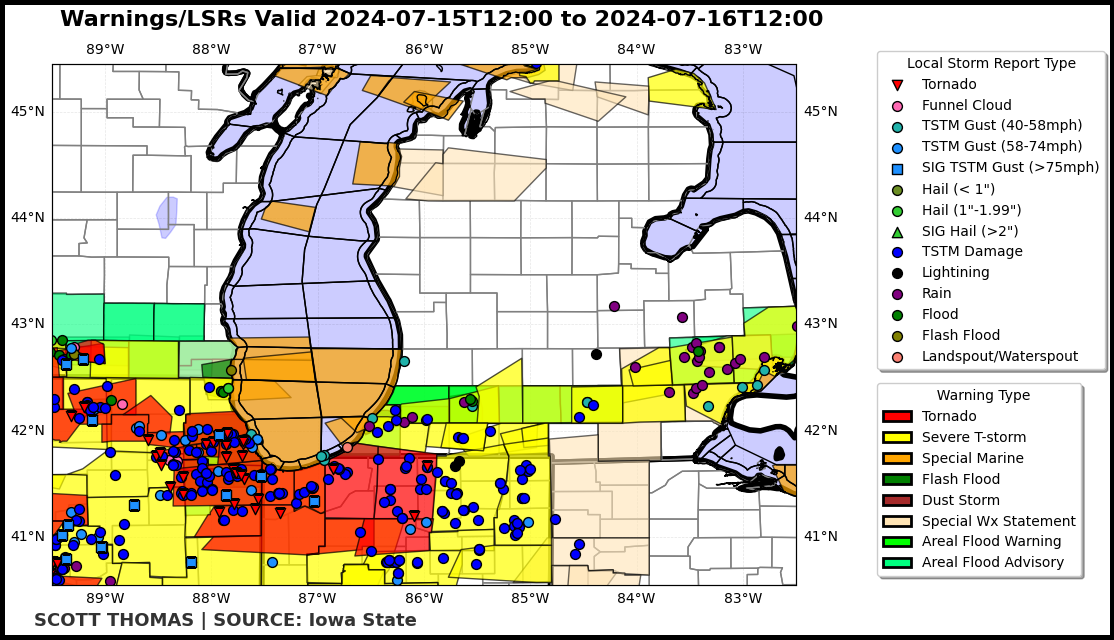

In [14]:
# @title
fig = plt.figure(figsize=(12, 12), facecolor='white', edgecolor="black", linewidth =6)
ax=fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
ax.set_extent((WestLong, EastLong, SouthLat, NorthLat))
ax.set_box_aspect(0.7)
axb = ax.twinx()
axb.set_box_aspect(0.7)
#Add Geometries
try:
  ax.add_geometries(TORWarn.geometry, crs = ccrs.PlateCarree(), facecolor =  'red', edgecolor = 'black', zorder = 998, alpha = 0.7)
  ax.add_geometries(SVRWarn.geometry, crs = ccrs.PlateCarree(), facecolor =  'yellow', edgecolor = 'black', zorder = 997, alpha = 0.7)
  ax.add_geometries(SMWWarn.geometry, crs = ccrs.PlateCarree(), facecolor =  'orange', edgecolor = 'black', zorder = 996, alpha = 0.7)
  ax.add_geometries(FFWWarn.geometry, crs = ccrs.PlateCarree(), facecolor =  'green', edgecolor = 'black', zorder = 995, alpha = 0.7)
  ax.add_geometries(DSWWarn.geometry, crs = ccrs.PlateCarree(), facecolor =  'brown', edgecolor = 'black', zorder = 994, alpha = 0.7)
  ax.add_geometries(SPSWarn.geometry, crs = ccrs.PlateCarree(), facecolor =  '#FFE4B5', edgecolor = 'black', zorder = 993, alpha = 0.6)
  ax.add_geometries(FAWWarn.geometry, crs = ccrs.PlateCarree(), facecolor =  '#00FF00', edgecolor = 'black', zorder = 992, alpha = 0.6)
  ax.add_geometries(FAYWarn.geometry, crs = ccrs.PlateCarree(), facecolor =  '#00FF7F', edgecolor = 'black', zorder = 991, alpha = 0.6)
except:
  pass
ax.add_geometries(MarZoneMap.geometry, crs = ccrs.PlateCarree(), facecolor = 'none', edgecolor = 'black',  zorder=999)

#Plot LSRs
ax.scatter(y = TORSR['LAT'], x = TORSR['LON'], zorder=1001, color = 'red', marker = 'v', edgecolor = 'black', label = 'Tornado', s = 55)
ax.scatter(y = FNCSR['LAT'], x = FNCSR['LON'], zorder=999, color = 'hotpink', label = 'Funnel Cloud', s = 50, edgecolor = 'black')
ax.scatter(y = SSTSGSR['LAT'], x = SSTSGSR['LON'], zorder=999, color = 'lightseagreen', label = 'TSTM Gust (40-58mph)', s = 50, edgecolor = 'black')
ax.scatter(y = TSGSR['LAT'], x = TSGSR['LON'], zorder=1000, color = 'dodgerblue', label = 'TSTM Gust (58-74mph)', s = 50, edgecolor = 'black')
ax.scatter(y = SIGTSGSR['LAT'], x = SIGTSGSR['LON'], zorder=1001, color = 'dodgerblue', label = 'SIG TSTM Gust (>75mph)', marker = 's', edgecolor = 'black', s = 55)
ax.scatter(y = SSHALSR['LAT'], x = SSHALSR['LON'], zorder=999, color = 'olivedrab', label = 'Hail (< 1")', s = 50, edgecolor = 'black')
ax.scatter(y = HALSR['LAT'], x = HALSR['LON'], zorder=1000, color = 'limegreen', label = 'Hail (1"-1.99")', s = 50, edgecolor = 'black')
ax.scatter(y = SIGHALSR['LAT'], x = SIGHALSR['LON'], zorder=1001, color = 'limegreen', label = 'SIG Hail (>2")', marker = '^', edgecolor = 'black', s = 55)
ax.scatter(y = SSMTGSR['LAT'], x = SSMTGSR['LON'], zorder=999, color = 'lightseagreen', s = 50, edgecolor = 'black')
ax.scatter(y = MTGSR['LAT'], x = MTGSR['LON'], zorder=999, color = 'dodgerblue', s = 50, edgecolor = 'black')
ax.scatter(y = SIGMTGSR['LAT'], x = SIGMTGSR['LON'], zorder=999, color = 'dodgerblue', s = 50, edgecolor = 'black', marker = 's',)
ax.scatter(y = TSDSR['LAT'], x = TSDSR['LON'], zorder=1000, color = 'blue', label = 'TSTM Damage', s = 50, edgecolor = 'black')
ax.scatter(y = LTGSR['LAT'], x = LTGSR['LON'], zorder=999, color = 'black', label = 'Lightining', s = 50, edgecolor = 'black')
ax.scatter(y = RANSR['LAT'], x = RANSR['LON'], zorder=999, color = 'purple', label = 'Rain', s = 50, edgecolor = 'black')
ax.scatter(y = FLDSR['LAT'], x = FLDSR['LON'], zorder=999, color = 'green', label = 'Flood', s = 50, edgecolor = 'black')
ax.scatter(y = FFDSR['LAT'], x = FFDSR['LON'], zorder=999, color = 'olive', label = 'Flash Flood', s = 50, edgecolor = 'black')
ax.scatter(y = WSTSR['LAT'], x = WSTSR['LON'], zorder=1000, color = 'salmon', label = 'Landspout/Waterspout', s = 50, edgecolor = 'black')
#ax.scatter(y = NTGSR['LAT'], x = NTGSR['LON'], zorder=999, color = 'gray', label = 'Non TSTSM Gust', s = 50, edgecolor = 'black')

TORW = mpatches.Rectangle((0, 0), 1, 0.1, linewidth=2, edgecolor='black', facecolor='red')
SMW = mpatches.Rectangle((0, 0), 1, 0.1, linewidth=2, edgecolor='black', facecolor='orange')
SVRW = mpatches.Rectangle((0, 0), 1, 0.1, linewidth=2, edgecolor='black', facecolor='yellow')
FFW = mpatches.Rectangle((0, 0), 1, 0.1, linewidth=2, edgecolor='black', facecolor='green')
DSTW = mpatches.Rectangle((0, 0), 1, 0.1, linewidth=2, edgecolor='black', facecolor='brown')
SPSW = mpatches.Rectangle((0, 0), 1, 0.1, linewidth=2, edgecolor='black', facecolor='#FFE4B5')
FAWW = mpatches.Rectangle((0, 0), 1, 0.1, linewidth=2, edgecolor='black', facecolor='#00FF00')
FAYW = mpatches.Rectangle((0, 0), 1, 0.1, linewidth=2, edgecolor='black', facecolor='#00FF7F')

axb.legend([TORW, SVRW, SMW, FFW, DSTW, SPSW, FAWW, FAYW], ['Tornado', 'Severe T-storm', 'Special Marine', 'Flash Flood', 'Dust Storm', 'Special Wx Statement', 'Areal Flood Warning', 'Areal Flood Advisory'],
            loc='upper left', fontsize=10, facecolor='white', markerscale=8,
            labelcolor='k', title='  Warning Type', title_fontsize=10,
           bbox_to_anchor=(1.10, 0.4), fancybox=True, shadow=True,).set_zorder(10)

ax.coastlines(color='black',resolution='10m',zorder=99)
ax.add_feature(cfeat.STATES.with_scale('50m'),edgecolor='black', zorder=9, linewidth = 4)
ax.add_feature(USCOUNTIES, facecolor='None', edgecolor='gray', zorder=9)
lake = cfeat.NaturalEarthFeature('physical', 'lakes', '50m', edgecolor='blue', facecolor='blue', alpha=0.2)
ax.add_feature(lake)
plt.figtext(0.11, 0.23, f'SCOTT THOMAS | SOURCE: Iowa State', weight='bold', color='black', fontsize=13, ha='left', alpha=0.8)
plt.figtext(0.45, 0.73, f'Warnings/LSRs Valid {Begins} to {Ends}', ha='center', weight='bold', fontsize=16)
gl = ax.gridlines(draw_labels = True, x_inline = False, y_inline = False, rotate_labels = False, linewidth = 0.5, linestyle = '--', color = 'black', alpha = 0.1)
gl.x_labels_top = False
gl.x_labels_bottom = True
axb.grid(False)
axb.set_xticks([])
axb.set_yticks([])
box1 = ax.get_position()
ax.set_position([box1.x0, box1.y0, box1.width * 0.8, box1 .height*0.95])
ax.legend(loc='lower left', bbox_to_anchor=(1.10, 0.4),
    ncol=1, fancybox=True, shadow=True, title = 'Local Storm Report Type')
plt.savefig(f'WarningsLSRs{Ends}.png', bbox_inches = 'tight')

#Clear All Data To Avoid Extraneous Variables For Future Plots

In [ ]:
# @title
#Clear CWA 2/3/4 Warnings, SPSs, and LSRs for Additional Plots
try:
  del TORWarn, SVRWarn, FFWWarn, SMWWarn, DSWWarn
except:
  pass
try:
  del TORSR, FNCSR, LTGSR, RANSR, HALSR, TSDSR, TSGSR, FLDSR, FFDSR, NTGSR, SIGTSGSR, SIGHALSR
except:
  pass
try:
  del SPSFile
except:
  pass